In [1]:
import numpy as np
import pandas as pd
from sklearn import tree,svm
from sklearn import model_selection
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.externals.six import StringIO
#import pydot
from IPython.display import Image
from sklearn import metrics
from mpl_toolkits.mplot3d import Axes3D
from sklearn.utils import shuffle,resample
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold,cross_val_score
import seaborn as sns
%matplotlib inline

# Problem 2

In [295]:
data = pd.read_csv('allhyper.data')
data['class'] = data['class'].str.rsplit('.',expand=True)[0]
data.dropna(axis=1, how='all', inplace=True)
label_types = data.dtypes.values
labels = data.columns

### Preprocessing

In [296]:
print 'percentage of class = "hyperthyroid" in the data:\t', (data[data['class']=='hyperthyroid'].shape[0]*1.0/data.shape[0])*100,'%'

percentage of class = "hyperthyroid" in the data:	2.21428571429 %


Because the value of the class is highly imbalanced such that the class only has 2.21 % of the key value 'hyperthyroid', the misclassification cannot exactly show the performance of models. So F1 score with 'recall' is more suitable for validate the performance of models. Particularly, F2 score may be more expected than F1 score **because it weights recall higher than precision by placing more emphasis on false negatives**.    

In [297]:
miss = pd.DataFrame(data.isnull().sum())/data.shape[0]*100
miss = pd.concat([miss,data.dtypes],axis=1)
miss.columns = ['percentage of missing values','data type']
miss[miss['percentage of missing values']>0]

,percentage of missing values,data type
age,0.035714,float64
sex,3.928571,object
TSH,10.142857,float64
T3,20.892857,float64
TT4,6.571429,float64
T4U,10.607143,float64
FTI,10.535714,float64


As you can see from the table above,
1. There are missing values in data set. We handle the missing values according to their typye:
(1) using the mean to fill 'float' missing values; (2) using the mode to fill the 'object' value.
2. Because original data are object values, we transform the **object vaues to binary values or multinomial values for convenient computations**. 
3. The original class are **multinomial class values, but here we only care about the 'hyperthyproid' and 'negative'**. So we transform **multinomial class values to binary values** such that '1' is 'hyperthyproid' and '0' is others classes including 'negative'.

In [298]:
for i in range(len(label_types)-1):
    if label_types[i] == 'float':
        data[labels[i]].fillna(data[labels[i]].mean(), inplace=True)
    else:
        data[labels[i]].fillna(data[labels[i]].mode()[0], inplace=True)
object_names = data.dtypes[data.dtypes=='object'].index.values
objects = {}
for key in object_names[:-1]: # not include 'class' column
    objects[key] = data.groupby(key).sum().index.values
objects

{'FTIInd': array(['f', 't'], dtype=object),
 'I131': array(['f', 't'], dtype=object),
 'T3Ind': array(['f', 't'], dtype=object),
 'T4UInd': array(['f', 't'], dtype=object),
 'TBGInd': array(['f'], dtype=object),
 'TSHInd': array(['f', 't'], dtype=object),
 'TT4Ind': array(['f', 't'], dtype=object),
 'goitre': array(['f', 't'], dtype=object),
 'hypopituitary': array(['f', 't'], dtype=object),
 'lithium': array(['f', 't'], dtype=object),
 'onAntithyroidMed': array(['f', 't'], dtype=object),
 'onThyroxine': array(['f', 't'], dtype=object),
 'preg': array(['f', 't'], dtype=object),
 'psych': array(['f', 't'], dtype=object),
 'queryHyperthyroid': array(['f', 't'], dtype=object),
 'queryHypothyroid': array(['f', 't'], dtype=object),
 'queryOnThyroxine': array(['f', 't'], dtype=object),
 'refSource': array(['STMW', 'SVHC', 'SVHD', 'SVI', 'other'], dtype=object),
 'sex': array(['F', 'M'], dtype=object),
 'sick': array(['f', 't'], dtype=object),
 'thySurg': array(['f', 't'], dtype=object),
 'tu

As you can see, most object-type values are binary type except for 'refSource'. So 'refSource' is transformed to a multinomial feature and others are transformed to binary features. In addition, the feature 'TBGInd' is full of single value such that it does not have influence on classification, so it can be removed.

In [299]:
for key, value in objects.items():
    for i in range(len(value)):
        data[key].replace(to_replace=value[i],value=i,inplace=True)
data.drop('TBGInd',axis=1,inplace=True)
data_y = pd.get_dummies(data['class']).iloc[:,2]
data.drop('class',axis=1,inplace=True)

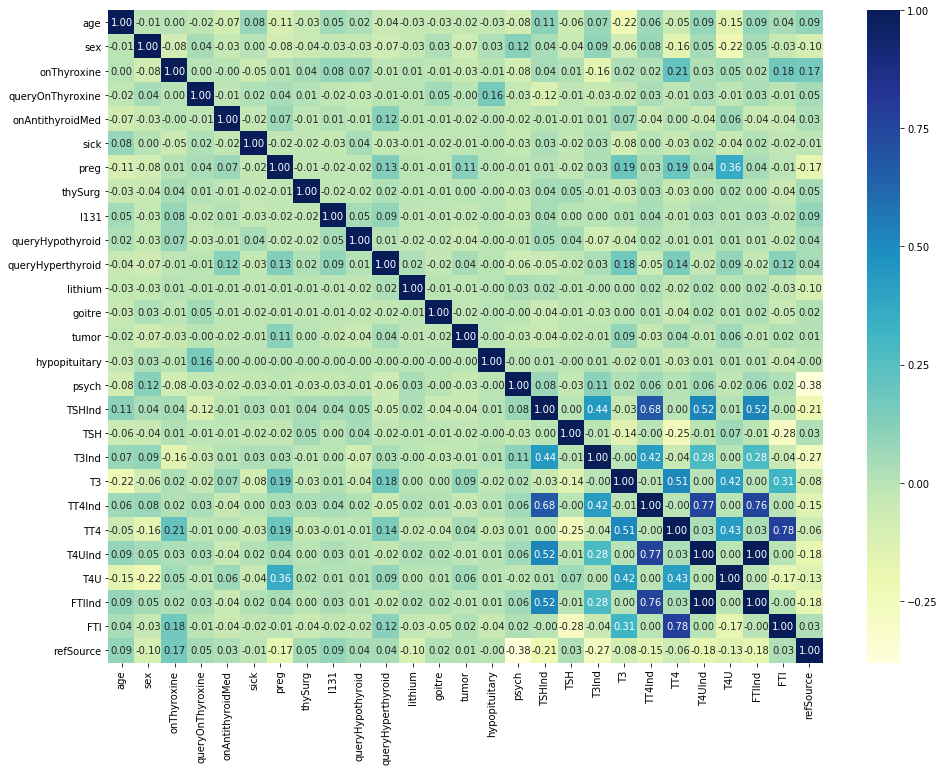

In [289]:
plt.figure(figsize=(16,12))
sns.heatmap(data.corr(),cmap="YlGnBu",annot=True,fmt='.2f')

In [300]:
data.drop('T4UInd',axis=1,inplace=True)

## (a)

In [294]:
class myRandomForest(object):
    def __init__(self, nest, criterion, maxDepth, minSamplesLeaf):
        self.nest = nest
        self.criterion = criterion
        self.maxDepth = maxDepth
        self.minSamplesLeaf = minSamplesLeaf
        self.forest = {}
        self.oob_dict = {}
        self.features = {}
        self.oob_score = {}
    def fit(self, trainX, trainY):
        self.labels = trainX.columns.values
        self.m = int(np.sqrt(trainX.shape[0]))
        for b in range(self.nest):
            x_train,y_train = resample(trainX,trainY,replace=True)
            x_test = trainX.loc[trainX.index.drop(x_train.index.unique())]
            y_test = trainY.loc[trainY.index.drop(y_train.index.unique())]
            new_labels = resample(self.labels,n_samples=self.m)
            dtc = tree.DecisionTreeClassifier(criterion=self.criterion, max_depth = self.maxDepth, min_samples_leaf=self.minSamplesLeaf)
            dtc.fit(x_train[new_labels],y_train)
            self.features[b] = new_labels 
            self.oob_dict[b] = (x_test,y_test)
            self.oob_score[b] = dtc.score(x_test[new_labels],y_test)
            self.forest[b] = dtc
        return 
    def fit2(self, trainX, trainY):
        self.labels = trainX.columns.values
        self.m = int(np.sqrt(trainX.shape[0]))
        for b in range(nest):
            x_train,y_train = resample(trainX,trainY,replace=True)
            x_test = trainX.loc[trainX.index.drop(x_train.index.unique())]
            y_test = trainY.loc[trainY.index.drop(y_train.index.unique())]
            self.features[b] = [] 
            new_t = self.build_tree(b, x_train,y_train, 1, x_train.shape[0])
            #self.oob_dict[b] = dtc.score(x_test[new_labels],y_test)
            self.forest[b] = new_t
        return 
    def build_tree(self, b, x, y, deep, size):
        if deep >= self.maxDepth:
            return 
        if size <= self.minSamplesLeaf:
            return
        d = {}
        new_labels = resample(self.labels,n_samples=self.m)
        t = tree.DecisionTreeClassifier(criterion=self.criterion, max_depth = 1)
        t.fit(x[new_labels],y)
        d['feature'] = new_labels[t.tree_.feature[0]]
        d['threshold'] = t.tree_.threshold[0]
        self.features[b].append(d['feature'])   
        temp_data = pd.concat([x,y],axis=1)
        data_left = temp_data.loc[x[d['feature']] < d['threshold']]
        data_right = temp_data.loc[x[d['feature']] >= d['threshold']]   
        left_y = data_left['hyperthyroid']
        right_y = data_right['hyperthyroid']
        data_left.drop('hyperthyroid',axis=1,inplace=True)
        data_right.drop('hyperthyroid',axis=1,inplace=True)      
        if data_left is not None :
            d['child_left'] = self.build_tree(b, data_left, left_y, deep+1, data_left.shape[0])
        if data_right is not None:
            d['child_right'] = self.build_tree(b, data_right, right_y, deep+1, data_right.shape[0])
        return d     
    def calc_features_importance(self,  B=-1):
        if B == -1:
            B = self.nest
        # calculate the feature importances of the whole random forest
        importance_dict = {}
        for item in self.labels:
            importance_dict[item] = 0.0
        for key in range(B):
            names = self.features[key]
            oobs = self.oob_dict[key]
            old_acc = self.oob_score[key]
            for i in range(len(names)):
                oobs_x = oobs[0].copy()
                oobs_x[names[i]] = np.random.permutation(oobs_x[names[i]])
                new_acc = self.forest[key].score(oobs_x[names],oobs[1])
                importance_dict[names[i]] = np.mean([importance_dict[names[i]],abs(old_acc-new_acc)])
        return importance_dict
    def calc_oob(self,  B=-1):
        if B == -1:
            B = self.nest
        total = 0.0
        for key in range(B):
            total += self.oob_score[key]
        return total/B
    def predict(self, x, B=-1):
        if B == -1:
            B = self.nest
        pre = []
        for key in range(B):
            pre.append(self.forest[key].predict(x[self.features[key]]))
        nonzeros = np.count_nonzero(pre,axis=0)
        result = []
        for item in nonzeros:
            result.append(1 if item >= (self.nest/2) else 0)
        return result
    def score(self, x, y,  B=-1):
        if B == -1:
            B = self.nest
        result = 0.0
        for key in range(B):
            result += self.forest[key].score(x[self.features[key]],y)
        return result/self.nest

In [315]:
trainX, testX, trainY, testY = model_selection.train_test_split(data, data_y, test_size=3.0/10)

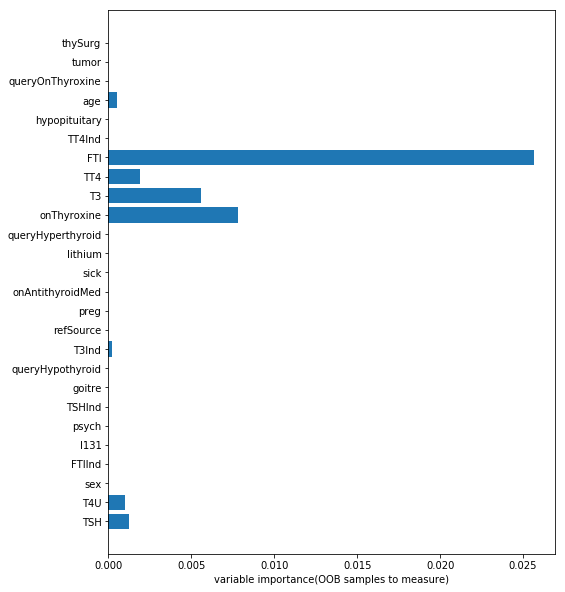

OOB accuracy:	0.985373383875
test set score:	0.982666666667
test set MSE:	0.0119047619048


In [317]:
nest = 25
criterion = 'gini'
maxDepth = 5
minSamplesLeaf = 5

myforest = myRandomForest(nest, criterion,maxDepth,minSamplesLeaf)
myforest.fit(trainX,trainY)
importance_dict = myforest.calc_features_importance()
y_pos = range(len(importance_dict.keys()))
fig = plt.figure(figsize=(8,10))
plt.barh(y_pos,importance_dict.values())
plt.yticks(y_pos,importance_dict.keys())
plt.xlabel('variable importance(OOB samples to measure)')
plt.show()

print 'OOB accuracy:\t', myforest.calc_oob()
print 'test set score:\t', myforest.score(testX,testY)
print 'test set MSE:\t', metrics.mean_squared_error(myforest.predict(testX),testY)

## (b)

In [302]:
def calc_scores(nest, criterion, x_index, y_index, train_x, train_y):
    result = {}
    for i in range(10,nest):
        result[i] = np.zeros((len(y_index),len(x_index)))
    
    for j in x_index: # min_samples_leaf = j    
        for k in y_index: # max_depth = k
            myForest = myRandomForest(nest, criterion,k,j)
            myForest.fit(train_x,train_y)
            for i in range(10,nest):
                result[i][k-1][j-1] = myForest.calc_oob(i)
    return result

In [318]:
x_index = range(1,36)
y_index = range(1,31)
X,Y = np.meshgrid(x_index,y_index)

score_dict_g = calc_scores(26, 'gini', x_index, y_index, trainX, trainY)
score_dict_e = calc_scores(26, 'entropy', x_index, y_index, trainX, trainY)

In [319]:
g_max_arr = []
e_max_arr = []
for i in range(10,26):
    g_max_arr.append(np.max(score_dict_g[i]))
    e_max_arr.append(np.max(score_dict_e[i]))
table = pd.DataFrame(data=[[np.max(g_max_arr),np.argmax(g_max_arr)+10],[np.max(e_max_arr),np.argmax(e_max_arr)+10]], index=['gini','entropy'],columns=['max_oob_score','optimal nest'])
table.head()


,max_oob_score,optimal nest
gini,0.989523,10
entropy,0.991690,13


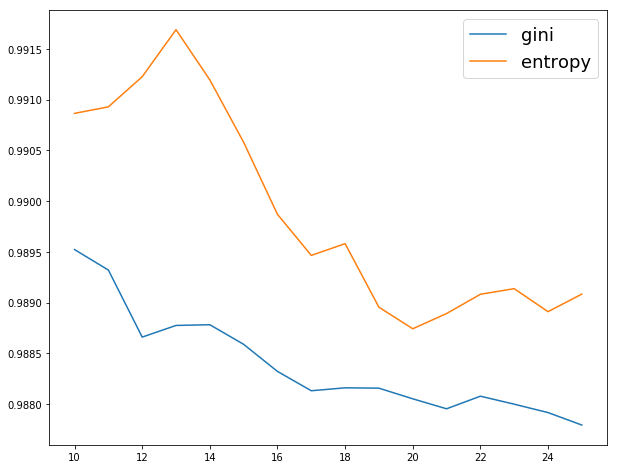

In [320]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(10,26),g_max_arr,label='gini')
plt.plot(range(10,26),e_max_arr,label='entropy')
plt.legend(fontsize=18)
plt.show()

As we can see in the figure above, the oob_score of entropy is better than that of gini. In addition, the optimal nest is 13 which can be seen in figure. So if we use the **oob sample accuracy** to choose parameter, **the best split criterion must be 'entropy' and the best nest is 13.** Because of the randomness of splits of data set and the features selection of random forest, the result is not the same every time. So for this data set, the entropy is more suitable for this data set and the nest value should not be too big, because excessive 'voters' easily introduce uncertainty and mess such that the entropy increases.

In [325]:
print 'Optimal Choices of parameters:'
print 'max_depth\t','min_samples_leaf'
print np.argmax(np.max(score_dict_e[13],axis=1))+1,'\t\t\t',np.argmax(np.max(score_dict_e[13],axis=0))+1

Optimal Choices of parameters:
max_depth	min_samples_leaf
2 			8


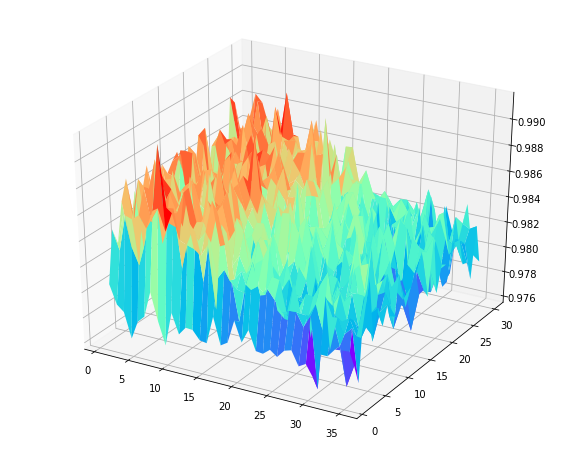

In [326]:
fig = plt.figure(figsize=(10,8))
ax1 = fig.gca(projection='3d')
ax1.plot_surface(X,Y,score_dict_e[13],rstride=1, cstride=1, cmap='rainbow')
fig.show()

## (c)

In [327]:
myForest = myRandomForest(13, 'entropy', np.argmax(np.max(score_dict_e[13],axis=1))+1,np.argmax(np.max(score_dict_e[13],axis=0))+1)
myForest.fit(trainX,trainY)
test_score = myForest.score(testX,testY)
best_oob = myForest.calc_oob()
print 'test_score\tbest_oob'
print test_score,'\t',best_oob

test_score	best_oob
0.980402930403 	0.983569661797


## (d)

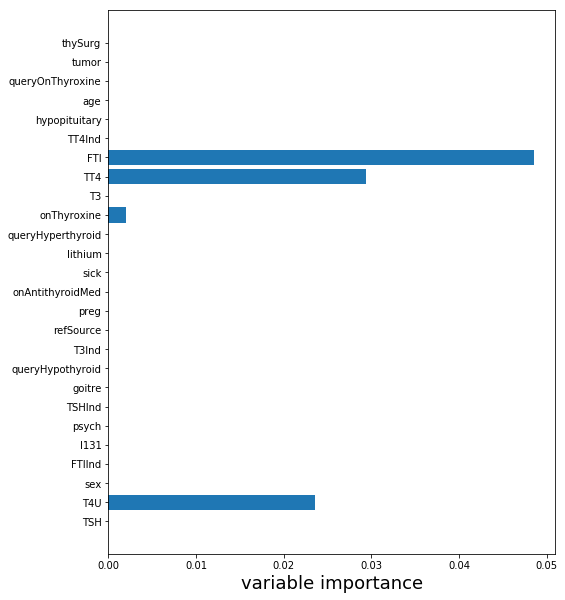

In [328]:
importance_dict = myForest.calc_features_importance()
y_pos = range(len(importance_dict.keys()))
fig = plt.figure(figsize=(8,10))
plt.barh(y_pos,importance_dict.values())
plt.yticks(y_pos,importance_dict.keys())
plt.xlabel('variable importance',fontsize=18)
plt.show()


### From the variable importance figure above, we can know that the most important features is the 'FTI'

# Problem 3

## (a)(b)

In [215]:
'''
    load data from txt file
'''
def load_data(filename):
    f = open(filename, 'r')
    k = 0
    data = f.read()
    f.close()
    data_list = data.split('\n')
    d = {}
    for line in data_list:
        if line != '' :
            arr = line.split(' ')
            d[k] = (arr[0],set(arr[1:]))
            k+=1
  
    return d
def construct_matrix(data,keys,features):
    y = []
    x = []
    for key in keys:
        y.append(data[key][0])
        temp = np.zeros(len(features))
        for i in range(len(features)):
            if features[i] in data[key][1]:
                temp[i] = 1
        x.append(temp)
    return np.array(x),np.array(y)
def get_data(split_rate):
    origin_d = load_data('spamAssassin.data')
    whole = shuffle(origin_d.keys())
    size = int(len(whole)*0.7)
    train_keys = whole[:size]
    test_keys = whole[size:]
    features = {}
    for key in train_keys:
        for word in origin_d[key][1]:
            try:
                features[word] += 1
            except :
                features[word] = 1
    for key in features.keys():
        if features[key] < 30 :
            del features[key]
    features_arr = features.keys()
    trainX,trainY = construct_matrix(origin_d, train_keys, features_arr)
    testX,testY = construct_matrix(origin_d, test_keys,features_arr)
    trainY = trainY.astype(int)
    np.place(trainY, trainY == 0, -1)
    testY = testY.astype(int)
    np.place(testY, testY == 0, -1)
    return trainX,trainY,testX,testY

## (c)(e)

In [260]:
class perceptron(object):
    def __init__(self, max_epoch = float('inf')):
        self.max_epoch = max_epoch
    
    def fit(self,x,y,shuffle_flag=False):
        self.mistakes = 0
        self.epochs = 0
        n,p = x.shape
        #x = x.as_matrix()
        self.w = np.ones(p)/(p*1.0)
        self.w0 = 0
        self.w_mean = np.ones(p)/(p*1.0)
        self.w0_mean = 0
        temp_mistakes = -1
        while temp_mistakes != 0:
            temp_mistakes = 0
            if shuffle_flag :   
                x,y = shuffle(x,y)
            for i in range(n):
                if y[i]*np.sign(self.w0+np.dot(self.w,x[i])) < 0:
                    temp_mistakes += 1
                    self.w = self.w + y[i]*x[i]
                    self.w0 = self.w0 + y[i]
                self.w_mean = np.add(self.w_mean,self.w)
                self.w0_mean += self.w0
            self.mistakes += temp_mistakes
            self.epochs += 1
            if self.epochs >= self.max_epoch:
                break
        self.w_mean /= (self.epochs*n*1.0)
        self.w0_mean /= (self.epochs*n*1.0)
    def test(self,x,y):
        n = x.shape[0]
        temp_errs = 0
        for i in range(n):
            if y[i]*np.sign(self.w0+np.dot(self.w,x[i])) < 0:
                temp_errs += 1
        return temp_errs*1.0/n
    def avg_test(self,x,y):
        n = x.shape[0]
        temp_errs = 0
        for i in range(n):
            if y[i]*np.sign(self.w0_mean+np.dot(self.w_mean,x[i])) < 0:
                temp_errs += 1
        return temp_errs*1.0/n


## (d)

In [273]:
trainX,trainY,testX,testY = get_data(0.7)

In [261]:
pct = perceptron()
pct.fit(trainX,trainY)
print 'Stop criterion: no new mistakes in train set'
print 'Mistakes:\t', pct.mistakes
print 'Estimated pridiction error:\t', pct.test(testX,testY)

Stop criterion: no new mistakes in train set
Mistakes:	464
Estimated pridiction error:	0.0194444444444


## (f)

1.If we do not shuffle data after training through the data each echo, which means the perceptron is trained by a fixed direction such that test error can converge. Although the method without shuffle cannot gaurantee that it can obtain the optimal classifier for the data, it is stable.

2.If we shuffle the data after each epoch. Because there is no fixed order of training sequence, it would not be outfiting to the data such that it can achieve better performance than that of the model without shuffle. However, the random training leads to instability on test error such that some time its performance is worse than that of model without shuffle.

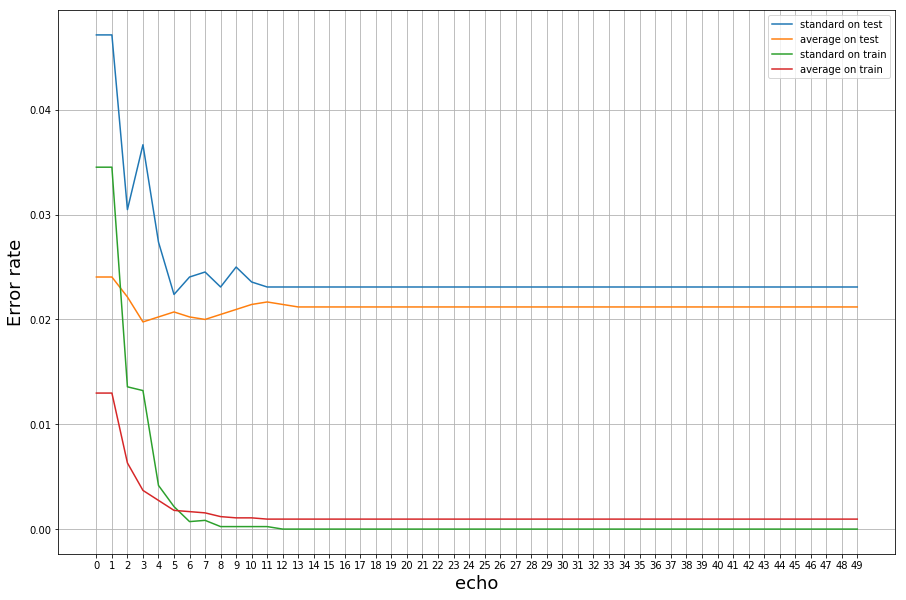

In [280]:
epochs = range(50)
std_err = []
avg_err = []
train_std = []
train_avg = []
kf = KFold(n_splits = 3)
for train_index,test_index in kf.split(trainX):
    train_x, test_x = trainX[train_index],trainX[test_index]
    train_y, test_y = trainY[train_index],trainY[test_index]
    temp_std_err = []
    temp_avg_err = []
    temp_train_std = []
    temp_train_avg = []
    for i in epochs:
        pct = perceptron(i)
        pct.fit(train_x,train_y,shuffle_flag=False)
        temp_std_err.append(pct.test(test_x,test_y))
        temp_avg_err.append(pct.avg_test(test_x,test_y))
        temp_train_std.append(pct.test(train_x,train_y))
        temp_train_avg.append(pct.avg_test(train_x,train_y))
    std_err.append(temp_std_err)
    avg_err.append(temp_avg_err)
    train_std.append(temp_train_std)
    train_avg.append(temp_train_avg)
std_err = np.mean(np.array(std_err),axis=0)
avg_err = np.mean(np.array(avg_err),axis=0)
train_std = np.mean(np.array(train_std),axis=0)
train_avg = np.mean(np.array(train_avg),axis=0)

plt.figure(figsize=(15,10))
plt.plot(epochs,std_err, label='standard on test')
plt.plot(epochs,avg_err, label='average on test')
plt.plot(epochs,train_std, label='standard on train')
plt.plot(epochs,train_avg, label='average on train')
plt.xticks(epochs)
plt.ylabel('Error rate',fontsize=18)
plt.xlabel('echo',fontsize=18)
plt.legend()
plt.grid(True)
plt.show()

1.It is obvious that the optimal model is **average perceptron**. The average model does not converge to exactly zero so the model does not be overfitting to the train set such that it achieve better performance on test set.

2.As we can see, the optimal echo of the model without shuffle must be **13** because the train error converge to zero and the test error would not change any more. In contrast, the optimal echo of the model with shuffle is **18** because the the train error of both two models converge to zero. After the train error converge to zero, the perceptron can separate the train set. If we shuffle data each echo, the perceptron changes among its 'safe' area of the train set such that the train error does not change but the test error changes. Therefore, I choose 18 as the optimal value of max echo of the model with shuffle.

## (g)

In [282]:
pct = perceptron(13)
pct.fit(trainX,trainY)
score = pct.avg_test(testX,testY)
print 'Test Error'
print score

Test Error
0.0183333333333


## (h)

In [283]:
sort_w = np.argsort(pct.w)
top = []
for i in sort_w[-15:][::-1]:
    top.append(features_arr[i])
tail = []
for i in sort_w[:15]:
    tail.append(features_arr[i])
table = pd.DataFrame(data=[top,tail],index=['top 15 positive weights','top 15 negative weights'])
table.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
top 15 positive weights,chri,neither,vehicl,greet,basenumb,yourself,distribut,am,why,registr,mike,databas,ps,prove,island
top 15 negative weights,higher,sight,depend,statement,anti,where,keyboard,massiv,flat,sign,not,around,latter,system,freedom


# Problem 4

In [341]:
data = pd.read_csv('allhyper.data')
data['class'] = data['class'].str.rsplit('.',expand=True)[0]
data.dropna(axis=1, how='all', inplace=True)
label_types = data.dtypes.values
labels = data.columns

## (a)

In [97]:
print 'percentage of class = "hyperthyroid" in the data:\t', (data[data['class']=='hyperthyroid'].shape[0]*1.0/data.shape[0])*100,'%'

percentage of class = "hyperthyroid" in the data:	2.21428571429 %


Because the value of the class is highly imbalanced such that the class only has 2.21 % of the key value 'hyperthyroid', the misclassification cannot exactly show the performance of models. So F1 score with 'recall' is more suitable for validate the performance of models. Particularly, F2 score may be more expected than F1 score **because it weights recall higher than precision by placing more emphasis on false negatives**.    

## (b) Preprocessing

In [98]:
miss = pd.DataFrame(data.isnull().sum())/data.shape[0]*100
miss = pd.concat([miss,data.dtypes],axis=1)
miss.columns = ['percentage of missing values','data type']
miss[miss['percentage of missing values']>0]

,percentage of missing values,data type
age,0.035714,float64
sex,3.928571,object
TSH,10.142857,float64
T3,20.892857,float64
TT4,6.571429,float64
T4U,10.607143,float64
FTI,10.535714,float64


As you can see from the table above,
1. There are missing values in data set. We handle the missing values according to their typye:
(1) using the mean to fill 'float' missing values; (2) using the mode to fill the 'object' value.
2. Because original data are object values, we transform the **object vaues to binary values or multinomial values for convenient computations**. 
3. The original class are **multinomial class values, but here we only care about the 'hyperthyproid' and 'negative'**. So we transform **multinomial class values to binary values** such that '1' is 'hyperthyproid' and '0' is others classes including 'negative'.

In [342]:
for i in range(len(label_types)-1):
    if label_types[i] == 'float':
        data[labels[i]].fillna(data[labels[i]].mean(), inplace=True)
    else:
        data[labels[i]].fillna(data[labels[i]].mode()[0], inplace=True)
object_names = data.dtypes[data.dtypes=='object'].index.values
objects = {}
for key in object_names[:-1]: # not include 'class' column
    objects[key] = data.groupby(key).sum().index.values
objects

{'FTIInd': array(['f', 't'], dtype=object),
 'I131': array(['f', 't'], dtype=object),
 'T3Ind': array(['f', 't'], dtype=object),
 'T4UInd': array(['f', 't'], dtype=object),
 'TBGInd': array(['f'], dtype=object),
 'TSHInd': array(['f', 't'], dtype=object),
 'TT4Ind': array(['f', 't'], dtype=object),
 'goitre': array(['f', 't'], dtype=object),
 'hypopituitary': array(['f', 't'], dtype=object),
 'lithium': array(['f', 't'], dtype=object),
 'onAntithyroidMed': array(['f', 't'], dtype=object),
 'onThyroxine': array(['f', 't'], dtype=object),
 'preg': array(['f', 't'], dtype=object),
 'psych': array(['f', 't'], dtype=object),
 'queryHyperthyroid': array(['f', 't'], dtype=object),
 'queryHypothyroid': array(['f', 't'], dtype=object),
 'queryOnThyroxine': array(['f', 't'], dtype=object),
 'refSource': array(['STMW', 'SVHC', 'SVHD', 'SVI', 'other'], dtype=object),
 'sex': array(['F', 'M'], dtype=object),
 'sick': array(['f', 't'], dtype=object),
 'thySurg': array(['f', 't'], dtype=object),
 'tu

As you can see, most object-type values are binary type except for 'refSource'. So 'refSource' is transformed to a multinomial feature and others are transformed to binary features. In addition, the feature 'TBGInd' is full of single value such that it does not have influence on classification, so it can be removed.

In [343]:
data.drop('TBGInd',axis=1,inplace=True)
objects.pop('TBGInd')
v = [-2,-1,0,1,2]
for key, value in objects.items():
    if key == 'refSource':
        for i in range(len(value)):   
            data[key].replace(to_replace=value[i],value=v[i],inplace=True)
    else:
        data[key].replace(to_replace=value[0],value=-1,inplace=True)
        data[key].replace(to_replace=value[1],value=1,inplace=True)
data_y = pd.get_dummies(data['class']).iloc[:,2]
data.drop('class',axis=1,inplace=True)

In [348]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,2800.0,51.844230,20.457505,1.000,36.0000,54.000000,67.00,455.00
sex,2800.0,-0.385714,0.922783,-1.000,-1.0000,-1.000000,1.00,1.00
onThyroxine,2800.0,-0.764286,0.644993,-1.000,-1.0000,-1.000000,-1.00,1.00
queryOnThyroxine,2800.0,-0.971429,0.237375,-1.000,-1.0000,-1.000000,-1.00,1.00
onAntithyroidMed,2800.0,-0.975714,0.219086,-1.000,-1.0000,-1.000000,-1.00,1.00
sick,2800.0,-0.921429,0.388617,-1.000,-1.0000,-1.000000,-1.00,1.00
preg,2800.0,-0.970714,0.240280,-1.000,-1.0000,-1.000000,-1.00,1.00
thySurg,2800.0,-0.972143,0.234431,-1.000,-1.0000,-1.000000,-1.00,1.00
I131,2800.0,-0.965714,0.259654,-1.000,-1.0000,-1.000000,-1.00,1.00
queryHypothyroid,2800.0,-0.883571,0.468380,-1.000,-1.0000,-1.000000,-1.00,1.00


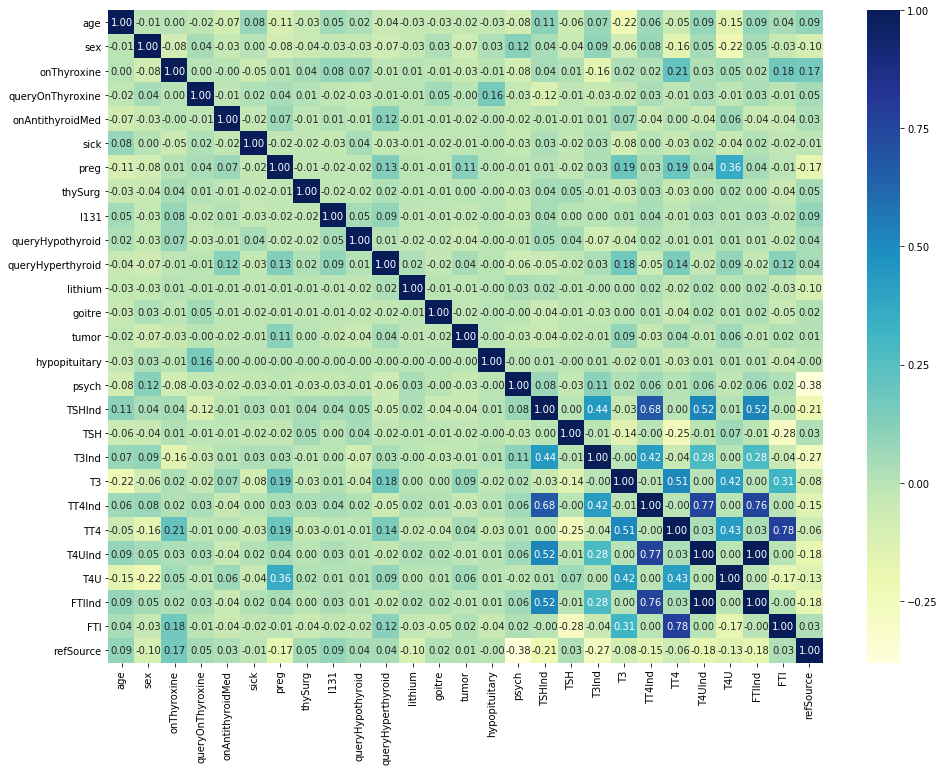

In [345]:
plt.figure(figsize=(16,12))
sns.heatmap(data.corr(),cmap="YlGnBu",annot=True,fmt='.2f')

As we can see, there is a **strong correlation between 'T4UInd' and 'FTIInd'**, so I decide to drop the 'T4UInd' because it also has a correlation with 'TT4Ind'.

In [346]:
data.drop('T4UInd',axis=1,inplace=True)

Because the **range** of some features are **very different** and the **SVM model are sensitive to the data**, we need to normalize the data. Because most features are binary, I dicide to do **min-max normalization** to [0,1].

In [347]:
data_y = np.ravel(data_y)
trainX, testX, trainY, testY = model_selection.train_test_split(data, data_y, test_size=3.0/10)
scaler = preprocessing.StandardScaler() 
scaler.fit(trainX) 
trainX = scaler.transform(trainX)
testX = scaler.transform(testX)

## (c)

In [358]:
def cv_score(model,X,Y,cv=5):
    kf = KFold(n_splits=cv)
    score = np.zeros(3)
    for train_index,test_index in kf.split(X):
        train_x, test_x = X[train_index],X[test_index]
        train_y, test_y = Y[train_index],Y[test_index]
        model.fit(train_x,train_y)
        pre = model.predict(test_x)
        temp = [1-metrics.accuracy_score(pre,test_y),metrics.f1_score(test_y,pre),metrics.fbeta_score(test_y,pre,beta=2.0)]
        score = np.mean([score,temp],axis=0)
    return score
def test_score(model,X,Y,test_x,test_y):
    model.fit(X,Y)
    pre = model.predict(test_x)
    score = [1-metrics.accuracy_score(pre,test_y),metrics.f1_score(pre,test_y),metrics.fbeta_score(pre,test_y,beta=2.0)]
    return score

For linear SVM, the important parameter must only be the 'C', so here I will use CV to find the optimal value of 'C'.

optimal parameter:
C =  2636.65089873
F2 score= 0.80095963055


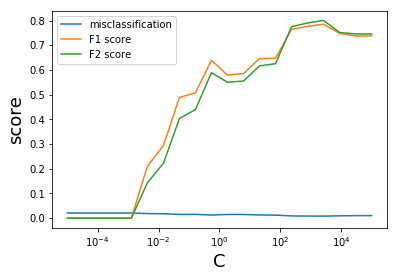

In [367]:
c_arr = np.logspace(-5,5,20)
lin_scores = []
for c in c_arr:
    lin = svm.SVC(C=c,kernel='linear')
    lin_score = cv_score(lin,trainX,trainY)
    lin_scores.append(lin_score)
lin_scores = np.array(lin_scores).transpose()
print 'optimal parameter:'
print 'C = ', c_arr[np.argmax(lin_scores[2])]
print 'F2 score=', np.max(lin_scores[2])
plt.plot(c_arr,lin_scores[0],label='misclassification')
plt.plot(c_arr,lin_scores[1],label='F1 score')
plt.plot(c_arr,lin_scores[2],label='F2 score')
plt.xscale('log')
plt.xlabel('C',fontsize=18)
plt.ylabel('score',fontsize=18)
plt.legend()
plt.show()

Then, according to the figure above, we know that the **optimal area of 'C' is (0.1,1000)**.

optimal parameter:
lin_opt_c =  923.670857187
F2 score = 0.802434573431


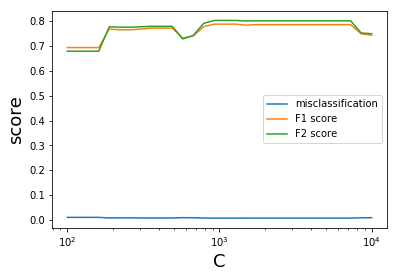

In [374]:
c_arr = np.logspace(2,4,30)
lin_scores = []
for c in c_arr:
    lin = svm.SVC(C=c,kernel='linear')
    lin_score = cv_score(lin,trainX,trainY)
    lin_scores.append(lin_score)
lin_scores = np.array(lin_scores).transpose()
print 'optimal parameter:'
lin_opt_c = c_arr[np.argmax(lin_scores[2])]
print 'lin_opt_c = ', lin_opt_c
print 'F2 score =', np.max(lin_scores[2])
plt.plot(c_arr,lin_scores[0],label='misclassification')
plt.plot(c_arr,lin_scores[1],label='F1 score')
plt.plot(c_arr,lin_scores[2],label='F2 score')
plt.xscale('log')
plt.xlabel('C',fontsize=18)
plt.ylabel('score',fontsize=18)
plt.legend()
plt.show()

In [375]:
lin = svm.SVC(C=lin_opt_c,kernel='linear')
train_scores = test_score(lin,trainX,trainY,trainX,trainY)
test_scores = test_score(lin,trainX,trainY,testX,testY)
table = pd.DataFrame(data=[train_scores,test_scores],index=['train','test'],columns=['Misclassification',' F1 score ', ' F2 score'])
table.head()

,Misclassification,F1 score,F2 score
train,0.004082,0.894737,0.880829
test,0.014286,0.739130,0.779817


## (d)

For polynomial kernel, there are two important parameters **'C' and 'degree'** where **'degree' is related to the power of polynomial kernel**. I use the CV to find the optimal parameters. 
First, I use a **wide range** of parameters **to check the approximate area** of the optimal parameters.

optimal parameter:
C =  69.5192796178 C_index= 13
Degree =  2
F2 score= 0.646995022903


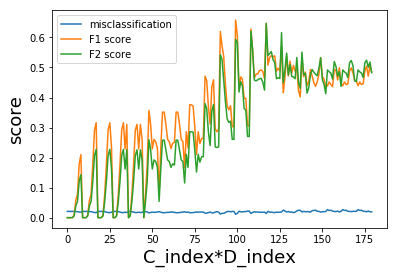

In [380]:
c_arr = np.logspace(-5,5,20)
d_arr = [2,3,4,5,6,7,8,9,10]

poly_scores =[]
for c in c_arr:
    for d in d_arr:
        poly = svm.SVC(C=c,kernel='poly',degree=d)
        score = cv_score(poly,trainX,trainY)
        poly_scores.append(score)
poly_scores = np.array(poly_scores).transpose()

arr = range(len(c_arr)*len(d_arr))
print 'optimal parameter:'
print 'C = ', c_arr[arr[np.argmax(poly_scores[2])]/len(d_arr)], 'C_index=', arr[np.argmax(poly_scores[2])]/len(d_arr)
print 'Degree = ', d_arr[arr[np.argmax(poly_scores[2])]%len(d_arr)]
print 'F2 score=', np.max(poly_scores[2])
plt.plot(arr,poly_scores[0],label='misclassification')
plt.plot(arr,poly_scores[1],label='F1 score')
plt.plot(arr,poly_scores[2],label='F2 score')
#plt.xscale('log')
plt.xlabel('C_index*D_index',fontsize=18)
plt.ylabel('score',fontsize=18)
plt.legend()
plt.show()

Then, according to the figure above, we know that the **optimal area of 'C' is (1,1000)**, and the **optimal area of 'degree' is [2,3,4,5]**.

optimal parameter:
poly_opt_c =  28.0721620394
poly_opt_degree =  2


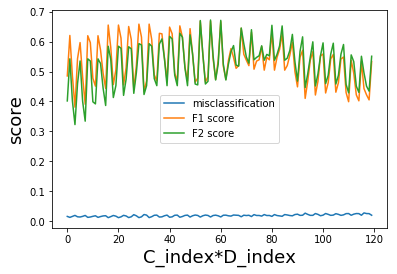

In [381]:
c_arr = np.logspace(0,3,30)
d_arr = [2,3,4,5]
poly_scores =[]
for c in c_arr:
    for d in d_arr:
        poly = svm.SVC(C=c,kernel='poly',degree=d)
        score = cv_score(poly,trainX,trainY)
        poly_scores.append(score)
poly_scores = np.array(poly_scores).transpose()

arr = range(len(c_arr)*len(d_arr))
print 'optimal parameter:'
poly_opt_c = c_arr[arr[np.argmax(poly_scores[2])]/len(d_arr)]
poly_opt_d = d_arr[arr[np.argmax(poly_scores[2])]%len(d_arr)]
print 'poly_opt_c = ', poly_opt_c
print 'poly_opt_degree = ', poly_opt_d
plt.plot(arr,poly_scores[0],label='misclassification')
plt.plot(arr,poly_scores[1],label='F1 score')
plt.plot(arr,poly_scores[2],label='F2 score')
#plt.xscale('log')
plt.xlabel('C_index*D_index',fontsize=18)
plt.ylabel('score',fontsize=18)
plt.legend()
plt.show()

In [384]:
poly = svm.SVC(C=poly_opt_c,kernel='poly',degree=poly_opt_d)
train_scores = test_score(poly,trainX,trainY,trainX,trainY)
test_scores = test_score(poly,trainX,trainY,testX,testY)
table = pd.DataFrame(data=[train_scores,test_scores],index=['train','test'],columns=['Misclassification',' F1 score ', ' F2 score'])
table.head()

,Misclassification,F1 score,F2 score
train,0.003571,0.904110,0.911602
test,0.019048,0.636364,0.693069


## (e)

For polynomial kernel, there are two important parameters **'C' and 'gamma'** where **'gamma' is related to the power of polynomial kernel**. I use the CV to find the optimal parameters. 
First, I use a **wide range** of parameters **to check the approximate area** of the optimal parameters.

optimal parameter:
C =  1274.2749857 C_index= 14
Degree =  0.00428133239872
F2 score= 0.749846888252


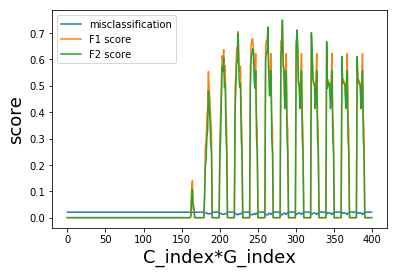

In [362]:
c_arr = np.logspace(-5,6,20)
g_arr = np.logspace(-3,3,20)
rbf_scores =[]
for c in c_arr:
    for g in g_arr:
        rbf = svm.SVC(C=c,kernel='rbf',gamma=g)
        score = cv_score(rbf,trainX,trainY)
        rbf_scores.append(score)
rbf_scores = np.array(rbf_scores).transpose()

arr = range(len(c_arr)*len(g_arr))
print 'optimal parameter:'
print 'C = ', c_arr[arr[np.argmax(rbf_scores[2])]/len(g_arr)], 'C_index=', arr[np.argmax(rbf_scores[2])]/len(g_arr)
print 'Degree = ', g_arr[arr[np.argmax(rbf_scores[2])]%len(g_arr)]
print 'F2 score=', np.max(rbf_scores[2])
plt.plot(arr,rbf_scores[0],label='misclassification')
plt.plot(arr,rbf_scores[1],label='F1 score')
plt.plot(arr,rbf_scores[2],label='F2 score')
#plt.xscale('log')
plt.xlabel('C_index*G_index',fontsize=18)
plt.ylabel('score',fontsize=18)
plt.legend()
plt.show()

Then, according to the figure above, we know that the **optimal area of 'C' is (100,10000)**, and the **optimal area of 'gamma' is [10^-4,10^-1]**.

optimal parameter:
rbf_opt_c =  303.919538231
rbf_opt_gamma =  0.00784759970351
F2 score= 0.755325797206


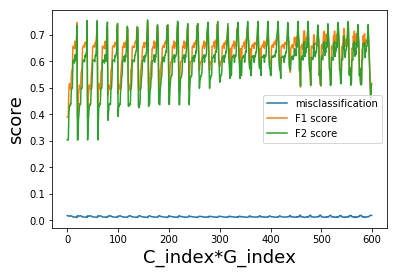

In [365]:
c_arr = np.logspace(2,4,30)
g_arr = np.logspace(-4,-2,20)
rbf_scores =[]
for c in c_arr:
    for g in g_arr:
        rbf = svm.SVC(C=c,kernel='rbf',gamma=g)
        score = cv_score(rbf,trainX,trainY)
        rbf_scores.append(score)
rbf_scores = np.array(rbf_scores).transpose()

arr = range(len(c_arr)*len(g_arr))
print 'optimal parameter:'
rbf_opt_c = c_arr[arr[np.argmax(rbf_scores[2])]/len(g_arr)]
rbf_opt_g = g_arr[arr[np.argmax(rbf_scores[2])]%len(g_arr)]
print 'rbf_opt_c = ', rbf_opt_c
print 'rbf_opt_gamma = ', rbf_opt_g
print 'F2 score=', np.max(rbf_scores[2])
plt.plot(arr,rbf_scores[0],label='misclassification')
plt.plot(arr,rbf_scores[1],label='F1 score')
plt.plot(arr,rbf_scores[2],label='F2 score')
#plt.xscale('log')
plt.xlabel('C_index*G_index',fontsize=18)
plt.ylabel('score',fontsize=18)
plt.legend()
plt.show()

In [366]:
rbf = svm.SVC(C=rbf_opt_c,kernel='rbf',gamma=rbf_opt_g)
train_scores = test_score(rbf,trainX,trainY,trainX,trainY)
test_scores = test_score(rbf,trainX,trainY,testX,testY)
table = pd.DataFrame(data=[train_scores,test_scores],index=['train','test'],columns=['Misclassification',' F1 score ', ' F2 score'])
table.head()

,Misclassification,F1 score,F2 score
train,0.002551,0.933333,0.925926
test,0.016667,0.708333,0.726496


## (f)

In [385]:
# after run the cells before, we now have three models with optimal parameters.
test_arr = []
train_arr = []
train_arr.append(test_score(lin,trainX,trainY,trainX,trainY))
train_arr.append(test_score(poly,trainX,trainY,trainX,trainY))
train_arr.append(test_score(rbf,trainX,trainY,trainX,trainY))
test_arr.append(test_score(lin,trainX,trainY,testX,testY))
test_arr.append(test_score(poly,trainX,trainY,testX,testY))
test_arr.append(test_score(rbf,trainX,trainY,testX,testY))


In [386]:
print 'Train table'
table = pd.DataFrame(data=train_arr,index=['linear','polynomial','RBF'],columns=['Misclassification',' F1 score ', ' F2 score'])
table.head()

Train table


,Misclassification,F1 score,F2 score
linear,0.004082,0.894737,0.880829
polynomial,0.003571,0.904110,0.911602
RBF,0.002551,0.933333,0.925926


In [389]:
print 'Test table '
table = pd.DataFrame(data=test_arr,index=['linear','polynomial','RBF'],columns=['Misclassification',' F1 score ', ' F2 score'])
table.head()

Test table 


,Misclassification,F1 score,F2 score
linear,0.014286,0.739130,0.779817
polynomial,0.019048,0.636364,0.693069
RBF,0.016667,0.708333,0.726496


In [388]:
print 'Parameter Table'

table = pd.DataFrame(data=[[lin_opt_c,0,0],[poly_opt_c,poly_opt_d,0],[rbf_opt_c,0,rbf_opt_g]],index=['linear','polynomial','RBF'],columns=['Optimal C','Optimal Degree', 'Optimal Gamma'])
table.head()

Parameter Table


,Optimal C,Optimal Degree,Optimal Gamma
linear,923.670857,0,0.000000
polynomial,28.072162,2,0.000000
RBF,303.919538,0,0.007848


### Conclusion

1.Because of the imbalanced data set, the three model cannot obtain ideal performance on test set. The models are easily to be overfitting because of the imbalance such that F score cannot reach higher. However, we can also see from the comparison table that F2 Score with high weighted recall is higher than the normal F1 Score. Therefore, for the  assessment criterion to the models on imbalanced data, F2 score is more suitable than misclassification and F1 score.

2.From the 'train table' and 'test table', we can see that given the imbalanced data, for the scores of the three model with their optimal parameters, linear model > the RBF kernel with gamma = 0.008 > the polynomial kernel with degree of 2 . Although random splits of data set and CV cause different results of the three models, this relationship between them is almost stable. 

3.From the 'Parameter table', we can see that the linear SVM needs the larger C for regularization because it needs larger penalty for 'slacks' to obtain a separable boundary. But the polynomial SVM and RBF needs the smaller C for regularization because they introduce kernels to obtain a boundary in a hyperplane with smaller penalty for 'slacks'.

4.The reason why the linear model is the best on test might be that other two models with kernel are overfitting to the train data (see "Train table") such that they achieve poor performance on test set (see "Test table"). Another possible reason might be the data is imbalanced such that the two kernel models are easy to be overfitting.  